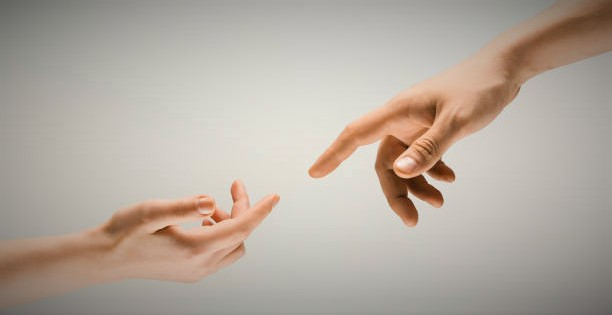

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,VotingClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import glob
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [57]:
Alone=0
Spontan=1
Sync=2

dictionary = {
    0 :'Alone',
    1 : 'Spontan',
    2 : 'Sync'
}
class_names = list(dictionary.values())

def LoadData(path):
        #create list for each state:
        AloneList=[];SpontanList=[];SyncList=[]
        all_files = glob.glob(path + "/*")
        for folder in all_files:
            print("\nloading in" ,os.path.basename(folder), ':')
            files = glob.glob(folder + "/*.csv")
            #find the 3 last files in each folder
            files=last3(files)
            for filename in files:
                df = pd.read_csv(filename, index_col=None, header=0)
                type = None
                
                if("Alone" in filename):
                    type = Alone
                    df=transform(df,type)
                    AloneList.append(df)
                elif("Sync" in filename):
                    type = Sync
                    df=transform(df,type)
                    SyncList.append(df)
                elif("Spontan" in filename):
                    type = Spontan
                    df=transform(df,type)
                    SpontanList.append(df)
                   
                print(os.path.basename(filename), type)
        listData = np.array([AloneList,SpontanList,SyncList])
        return listData


def last3(files):
    lafile=[]
    for i in range(3):
        latest_file = max(files, key=os.path.getmtime)
        lafile.append(latest_file)
        files.remove(latest_file)
    return lafile

def transform(df,type):
    #first, remove rows with NaN value.
    df=df.dropna().reset_index(drop=True)
    # restart the seconds in 'Time' column
    df.iloc[:,0] = df.iloc[:,0] - df.iloc[:,0][0]
    # remove 7 first seconds.
    df = remove7(df)
    df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]
    # round each number in 'Time' column.
    df.iloc[:,0] = df.iloc[:,0].astype(int)
    
    if type==0:# if this Alone data:
        df = df[df.iloc[:,3] == 1]
        return df
    #clean all values that the camera did not capture both hands in the same frame
    df = df[df.iloc[:,3] != 1]
    #now the 'hands' column is not needed so remove it
    df = df.drop(columns=df.columns[3])
    #split the data to right and left
    df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
    df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
    
    #After merging left and right columns, the "HandType" column is not needed.
    df_right = df_right.drop(columns=df_right.columns[2])
    df_left = df_left.drop(columns=df_left.columns[2])
    df=pd.merge(df_right, df_left, left_index=True, right_index=True)
    df.columns=[c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
    return df

    # this function remove 7 first second from the Data
def remove7(df):
    return df[df.iloc[:,0]>7].reset_index(drop=True)

In [58]:
pathTrain=r'C:\Users\נעמיה\data-science\extraFiles\Training'
pathTest=r'C:\Users\נעמיה\data-science\extraFiles\Validation'
print('Load the train data:')
listTrain=LoadData(pathTrain)
print('\nLoad the test data:')
listTest=LoadData(pathTest)

Load the train data:

loading in Evyatar Cohen :
Evyatar636771054555711409Alone.csv 0
Evyatar636771053639929594Sync.csv 2
Evyatar636771052727603804Spontan.csv 1

loading in Nofar Social_Nuero :
Nofar636759797397919664Sync.csv 2
Nofar636759796290435160Alone.csv 0
Nofar636759795182793299Spontan.csv 1

loading in Oriya Social_Nuero :
Oriya636759806131350399Sync.csv 2
Oriya636759805268396661Alone.csv 0
Oriya636759804404113837Spontan.csv 1

loading in Orya Kalmanovitz :
OryaB636771084494502229Sync.csv 2
OryaB636771083605535985Spontan.csv 1
OryaB636771082736601528Alone.csv 0

loading in Revital Marbel :
Revital636770957894370062Sync.csv 2
Revital636770957038873193Spontan.csv 1
Revital636770955999435879Alone.csv 0

loading in Shahar Terner :
Sachar636771047408504303Alone.csv 0
Sachar636771046527112972Sync.csv 2
Sachar636771045591258071Spontan.csv 1

loading in Shelly Social_Nuero :
Shelly636759789526313406Sync.csv 2
Shelly636759788383205274Alone.csv 0
Shelly636759787508979097Spontan.csv 1

lo

In [59]:
print(listTrain.shape)
print(listTest.shape)

(3, 9)
(3, 3)


In [60]:
AloneRight = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\HandRight.csv')
AloneRight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [61]:
#drop rows with NaN value
AloneRight = AloneRight.dropna()

#change columns name
AloneRight = transform(AloneRight,0)

#replace 'left' at 'right'
for index, row in AloneRight.iterrows():
    AloneRight.loc[index,'HandType']='right'
    
#if there are duplicate rows - delete them
AloneRight=AloneRight.drop_duplicates().reset_index(drop=True)

In [62]:
def mergeAlone(listdata):
    for i in range(len(listdata)):
        temp=AloneRight
        
        #If AloneLeft has more rows than AloneRight, double AloneRight
        if len(listdata[i])>len(AloneRight):
            temp=pd.concat([AloneRight,AloneRight]).reset_index(drop=True)
            
        # find the spare rows in AloneRight:
        spare = len(temp)-len(listdata[i])
        temp = temp.drop(temp.tail(spare).index)
        
        temp = temp.drop(columns=temp.columns[[2,3]])
        listdata[i] = listdata[i].drop(columns=listdata[i].columns[[2,3]])
        
        df=pd.merge(temp, listdata[i], left_index=True, right_index=True)
        df.columns = [c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
        listdata[i] = df.reset_index(drop=True)
    return listdata

In [63]:
listTrain[Alone]=mergeAlone(listTrain[Alone])
listTest[Alone]=mergeAlone(listTest[Alone])

In [64]:
aa1=listTrain[0][1].query('30<=TimeRight<=32').iloc[::2,]
aa2=listTrain[1][1].query('30<=TimeRight<=32').iloc[::2,]
aa3=listTrain[2][1].query('30<=TimeRight<=32').iloc[::2,]

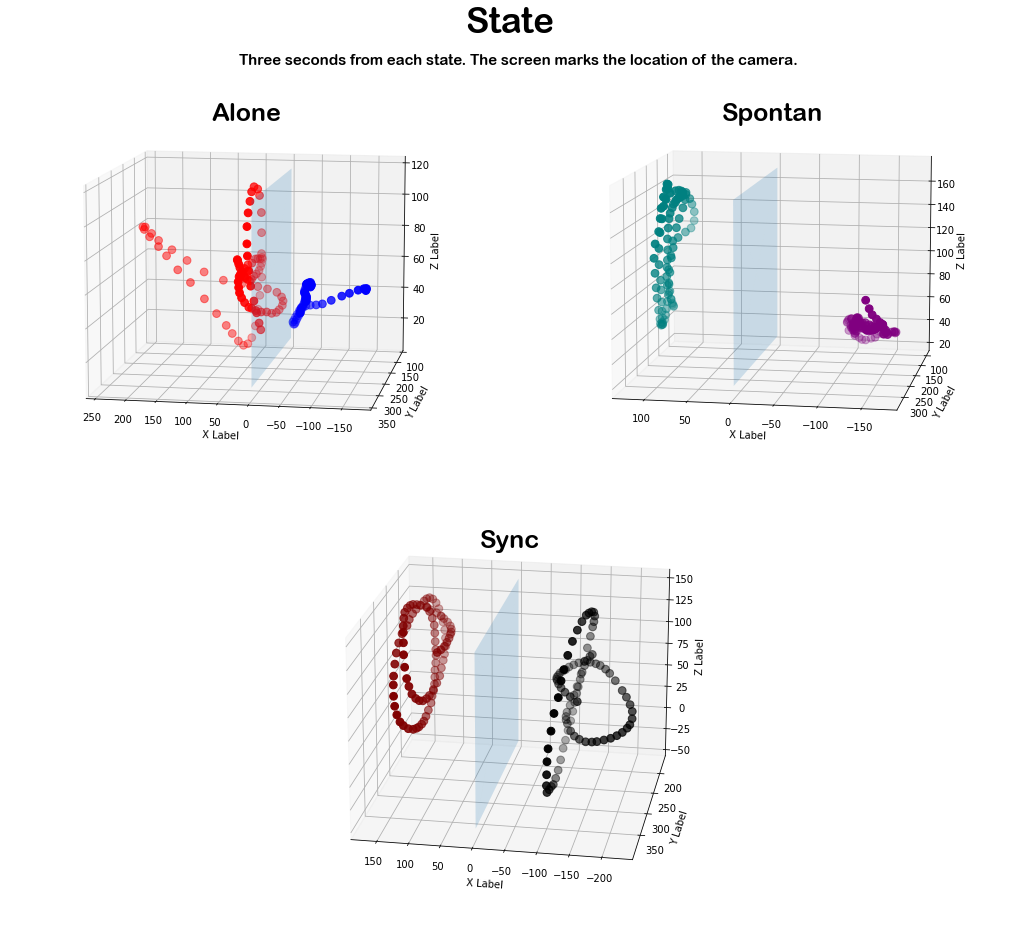

In [65]:
def Max(sr1,sr2):
    return max(max(sr1),max(sr2))
def Min(sr1,sr2):
    return min(min(sr1),min(sr2))

def scatterplot(df,c1,c2,title,elev,azim):
    ax.scatter(df['PositionXRight'], df['PositionYRight'], df['PositionZRight'], c=c1, marker='o',s=60)
    ax.scatter(df['PositionXLeft'], df['PositionYLeft'], df['PositionZLeft'], c=c2, marker='o',s=60)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ymin=Min(df['PositionYLeft'],df['PositionYRight'])
    zmin=Min(df['PositionZLeft'],df['PositionZRight'])
    ymax=Max(df['PositionYLeft'],df['PositionYRight'])
    zmax=Max(df['PositionZLeft'],df['PositionZRight'])
    x = [0, 0, 0, 0]
    y = [ymin, ymin, ymax, ymax]
    z = [zmin, zmax, zmin, zmax]
    vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
    tupleList = list(zip(x, y, z))
    poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
    collection = Poly3DCollection(poly3d, linewidths=1, alpha=0.1)
    ax.add_collection3d(collection)
    ax.set_title(title,fontsize = 25, fontweight='light',fontfamily=font, y=0.93)
    ax.view_init(elev,azim)
font='Arial Rounded MT Bold'
fig = plt.figure(3,figsize=(18,25),)
plt.text(x=0.231,y=1,s='Three seconds from each state. The screen marks the location of the camera.',fontfamily=font,fontsize = 15)
plt.title('State',fontsize = 35, fontweight='bold',fontfamily=font, y=1.03)
plt.axis('off')
ax = fig.add_subplot(221, projection='3d')
scatterplot(aa1,'r','b','Alone',10,100)
ax = fig.add_subplot(222, projection='3d')
scatterplot(aa2,'teal','purple','Spontan',10,100)
ax = fig.add_subplot(212, projection='3d')
scatterplot(aa3,'maroon','black','Sync',20,100)
plt.subplots_adjust(wspace=0.1,top=0.6,hspace=0.001)


In [66]:
def DataToVectors(df):
    first=df['TimeLeft'][0]
    last=df['TimeLeft'].iloc[-1]
    vecArr=[]
    for sec in range(first,last):
        secData=df[df['TimeLeft']==sec].iloc[::5,:].reset_index(drop=True)
        if len(secData)>=4:
            rowArr=[]
            for index in range(0,4):
                row = secData.loc[[index]].reset_index(drop=True)
                for column in row.columns:
                    newCol = column+"_{}".format(str(index))
                    row.columns = [c.replace(column, newCol) for c in row.columns]
                rowArr.append(row)
        vector=pd.concat(rowArr,axis=1,join='inner')
        vecArr.append(vector)
    newData=pd.concat(vecArr).reset_index(drop=True)
    newData = dropCol(newData,'Time')
    newData = dropCol(newData,'ID')
    return newData

def dropCol(df,value):
    df= df[df.columns.drop(list(df.filter(regex=value)))]
    return df

# union all data to one DataFrame:
def Union(df):
    DataArr=[]
    for i in range(len(df)):
        for j in range(len(df[i])):
            temp = DataToVectors(df[i][j])

#             Add 'State' column to df
            temp['State'] = i
            DataArr.append(temp)
    AllData = pd.concat(DataArr).reset_index(drop=True)
    return AllData
        

In [67]:

listVal=[];templistTrain=[]
for i in range(len(listTrain)):
    tempVal=listTrain[i][8]
    temp = np.delete(listTrain[i],8)
    templistTrain.append(temp)
    listVal.append(tempVal)
listVal=np.array(listVal).reshape(3,1)
templistTrain= np.array(templistTrain)
listTrain = templistTrain

In [68]:
print(listTrain.shape)
print(listTest.shape)

(3, 8)
(3, 3)


In [69]:
AllTrain = Union(listTrain)
AllVal= Union(listVal)
AllTest = Union(listTest)

In [70]:
x_train = AllTrain.drop('State',axis=1)
y_train = AllTrain['State']
x_val = AllVal.drop('State',axis=1)
y_val = AllVal['State']
x_test = AllTest.drop('State',axis=1)
y_test = AllTest['State']

In [112]:
print('Dimensions x_train:',x_train.shape)
print('Dimensions x_val:',x_val.shape)
print('Dimensions x_test:',x_test.shape)

Dimensions x_train: (1600, 144)
Dimensions x_val: (201, 144)
Dimensions x_test: (596, 144)


In [72]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

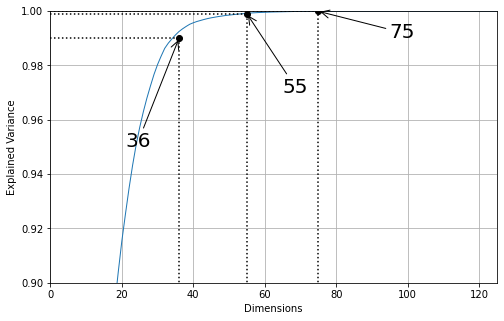

In [73]:
d = np.argmax(cumsum >= 0.9999) + 1
d1 = np.argmax(cumsum >= 0.999) + 1
d2 = np.argmax(cumsum >= 0.99) + 1
plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=1)
plt.axis([0, d+50, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.9999], "k:")
plt.plot([0, d], [0.9999, 0.9999], "k:")
plt.plot(d, 0.9999, "ko")
plt.annotate(d, xy=(d, 0.9999), xytext=(d+20, 0.99),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d1, d1], [0, 0.999], "k:")
plt.plot([0, d1], [0.999, 0.999], "k:")
plt.plot(d1, 0.999, "ko")
plt.annotate(d1, xy=(d1, 0.999), xytext=(d1+10, 0.97),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d2, d2], [0, 0.99], "k:")
plt.plot([0, d2], [0.99, 0.99], "k:")
plt.plot(d2, 0.99, "ko")
plt.annotate(d2, xy=(d2, 0.99), xytext=(d2-15, 0.95),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.grid(True)
plt.ylim(0.9,1)
plt.show()

In [74]:
pca = PCA(n_components=0.999)
x_train_pca=pca.fit_transform(x_train)
x_val_pca=pca.transform(x_val)
x_test_pca=pca.transform(x_test)

In [75]:
print('Dimensions x_train_pca:',x_train_pca.shape)
print('Dimensions x_val_pca:',x_val_pca.shape)
print('Dimensions x_test_pca:',x_test_pca.shape)

Dimensions x_train_pca: (1600, 55)
Dimensions x_val_pca: (201, 55)
Dimensions x_test_pca: (596, 55)


In [76]:
pipe_dum = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy', DummyClassifier())
])
pipe_dum.fit(x_train_pca, y_train)
dumpred = pipe_dum.predict(x_val_pca)
pred=[]
pred.append(dumpred)
accuracydum=accuracy_score(y_val, dumpred)

In [77]:
print(classification_report(y_val, dumpred,digits=3,target_names=class_names,zero_division =0))

              precision    recall  f1-score   support

       Alone      0.000     0.000     0.000        67
     Spontan      0.333     1.000     0.500        67
        Sync      0.000     0.000     0.000        67

    accuracy                          0.333       201
   macro avg      0.111     0.333     0.167       201
weighted avg      0.111     0.333     0.167       201



In [78]:
n_estimators = [int(x) for x in np.linspace(200, 2000, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

In [79]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
rf_tun = RandomizedSearchCV(estimator = pipe_rf, param_distributions= rf_grid, cv = 5,n_iter=20,n_jobs = -1)
rf_tun.fit(x_train_pca, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100,
                                                          110, None],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [200, 300, 400, 500,
                                                             600, 700, 800, 900,
                                                             1000, 1100, 1200,
        

In [80]:
print('Best param of RandomSearch - RandomForest:',rf_tun.best_params_)
print('Best Score of RandomSearch - RandomForest:',rf_tun.best_score_)

Best param of RandomSearch - RandomForest: {'rf__n_estimators': 1100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 80, 'rf__bootstrap': True}
Best Score of RandomSearch - RandomForest: 0.8306250000000001


In [81]:
pipe_rf.set_params(**rf_tun.best_params_)
pipe_rf.fit(x_train_pca, y_train)
rfpred = pipe_rf.predict(x_val_pca)
pred.append(rfpred)
accuracyrf=accuracy_score(y_val, rfpred)

In [82]:
print(classification_report(y_val, rfpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.670     0.970     0.793        67
        Sync      0.946     0.522     0.673        67

    accuracy                          0.831       201
   macro avg      0.872     0.831     0.822       201
weighted avg      0.872     0.831     0.822       201



In [83]:
rfpred1 = pipe_rf.predict(x_test_pca)
print(classification_report(y_test, rfpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.965     1.000     0.982       194
     Spontan      0.673     0.930     0.781       201
        Sync      0.906     0.527     0.667       201

    accuracy                          0.817       596
   macro avg      0.848     0.819     0.810       596
weighted avg      0.847     0.817     0.808       596



Text(0, 0.5, 'Testing Accuracy')

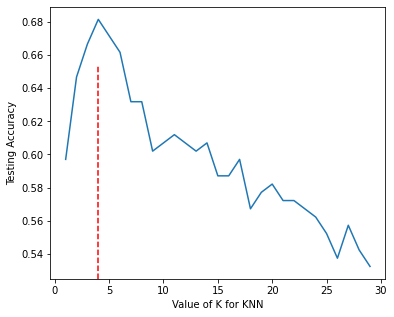

In [84]:
sc=[];k_range = list(range(1, 30))
for k in k_range:
    temppipe=Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    temppipe.fit(x_train_pca, y_train)
    sc.append(temppipe.score(x_val_pca,y_val))
m=sc.index(max(sc))+1
#plot graph showing percentage of accuracy by number of neighbors
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, sc)
ax.axvline(m, ls='--',ymax=max(sc)+0.1,c='r',solid_capstyle='round')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [85]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=m))
])
pipe_knn.fit(x_train_pca, y_train)
knnpred = pipe_knn.predict(x_val_pca)
pred.append(knnpred)
accuracyknn=accuracy_score(y_val, knnpred)

In [86]:
print(classification_report(y_val, knnpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.922     0.701     0.797        67
     Spontan      0.589     0.642     0.614        67
        Sync      0.610     0.701     0.653        67

    accuracy                          0.682       201
   macro avg      0.707     0.682     0.688       201
weighted avg      0.707     0.682     0.688       201



In [87]:
knnpred1 = pipe_knn.predict(x_test_pca)
print(classification_report(y_test, knnpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.988     0.814     0.893       194
     Spontan      0.657     0.761     0.705       201
        Sync      0.690     0.697     0.693       201

    accuracy                          0.757       596
   macro avg      0.778     0.757     0.764       596
weighted avg      0.775     0.757     0.762       596



In [88]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000))
])
lr_grid = {'lr__penalty' : ['l1', 'l2'],'lr__C' : np.logspace(-4, 4, 20),'lr__solver' : ['liblinear']}
lr_tun = RandomizedSearchCV(estimator = pipe_lr, param_distributions= lr_grid, cv = 5,n_iter=100, n_jobs = -1)
lr_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - LogisticRegression:',lr_tun.best_params_)
print('Best Score of RandomSearch - LogisticRegression:',lr_tun.best_score_)

Best param of RandomSearch - LogisticRegression: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 0.012742749857031334}
Best Score of RandomSearch - LogisticRegression: 0.8337499999999999


In [89]:
pipe_lr.set_params(**lr_tun.best_params_)
pipe_lr.fit(x_train_pca, y_train)
lrpred = pipe_lr.predict(x_val_pca)
pred.append(lrpred)
accuracylr=accuracy_score(y_val, lrpred)

In [90]:
print(classification_report(y_val, lrpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.700     0.836     0.762        67
        Sync      0.796     0.642     0.711        67

    accuracy                          0.826       201
   macro avg      0.832     0.826     0.824       201
weighted avg      0.832     0.826     0.824       201



In [91]:
lrpred1 = pipe_lr.predict(x_test_pca)

In [92]:
print(classification_report(y_test, lrpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.990     0.995     0.992       194
     Spontan      0.647     0.930     0.763       201
        Sync      0.875     0.488     0.626       201

    accuracy                          0.802       596
   macro avg      0.837     0.804     0.794       596
weighted avg      0.835     0.802     0.792       596



In [93]:
et_grid = {'et__n_estimators': n_estimators,
               'et__max_features': max_features,
               'et__max_depth': max_depth,
               'et__min_samples_split': min_samples_split,
               'et__min_samples_leaf': min_samples_leaf,
               'et__bootstrap': bootstrap}
pipe_et = Pipeline([
    ('scaler', StandardScaler()),
    ('et', ExtraTreesClassifier())
])
et_tun = RandomizedSearchCV(estimator = pipe_et, param_distributions = et_grid, cv = 5, n_iter=20,n_jobs=-1)
et_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - ExtraTrees:',et_tun.best_params_)
print('Best Score of RandomSearch - ExtraTrees:',et_tun.best_score_)

Best param of RandomSearch - ExtraTrees: {'et__n_estimators': 1100, 'et__min_samples_split': 2, 'et__min_samples_leaf': 2, 'et__max_features': 'sqrt', 'et__max_depth': 110, 'et__bootstrap': True}
Best Score of RandomSearch - ExtraTrees: 0.843125


In [94]:
pipe_et.set_params(**et_tun.best_params_)
pipe_et.fit(x_train_pca, y_train)
etpred = pipe_et.predict(x_val_pca)
pred.append(etpred)
accuracyet=accuracy_score(y_val, etpred)

In [95]:
print(classification_report(y_val, etpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.985     1.000     0.993        67
     Spontan      0.681     0.955     0.795        67
        Sync      0.949     0.552     0.698        67

    accuracy                          0.836       201
   macro avg      0.872     0.836     0.829       201
weighted avg      0.872     0.836     0.829       201



In [96]:
etpred1 = pipe_et.predict(x_test_pca)
print(classification_report(y_test, etpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.970     1.000     0.985       194
     Spontan      0.674     0.925     0.780       201
        Sync      0.892     0.532     0.667       201

    accuracy                          0.817       596
   macro avg      0.845     0.819     0.810       596
weighted avg      0.844     0.817     0.808       596



In [97]:
maxd = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
n_est= [200, 400, 600, 800, 1000, 1200, 1400,1600, 1800,2000]
lr= [0.1, 0.01,0.2,0.3, 0.05]
subsample= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree= [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bylevel=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_child_weight=[0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
gamma=[0, 0.25, 0.5, 1.0]
reg_lambda= [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
xgb_grid = dict(xgb__n_estimators=n_est,xgb__learning_rate=lr,xgb__colsample_bytree=colsample_bytree,
                  xgb__subsample=subsample,
                  xgb__colsample_bylevel=colsample_bylevel,
                  xgb__min_child_weight=min_child_weight,
                  xgb__reg_lambda=reg_lambda,
                  xgb__gamma=gamma,
                  xgb__max_depth=maxd)
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',XGBClassifier(n_estimators=500,use_label_encoder=False,eval_metric='mlogloss'))
])
xgb_tun = RandomizedSearchCV(estimator = pipe_xgb, param_distributions = xgb_grid, cv = 5,n_jobs=-1)
xgb_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - XGBoost:',xgb_tun.best_params_)
print('Best Score of RandomSearch - XGBoost:',xgb_tun.best_score_)

Best param of RandomSearch - XGBoost: {'xgb__subsample': 1.0, 'xgb__reg_lambda': 50.0, 'xgb__n_estimators': 400, 'xgb__min_child_weight': 3.0, 'xgb__max_depth': 80, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.25, 'xgb__colsample_bytree': 0.9, 'xgb__colsample_bylevel': 0.8}
Best Score of RandomSearch - XGBoost: 0.8306250000000001


In [98]:
pipe_xgb.set_params(**xgb_tun.best_params_)
pipe_xgb.fit(x_train_pca, y_train)
xgbpred = pipe_xgb.predict(x_val_pca)
pred.append(xgbpred)
accuracyxgb=accuracy_score(y_val, xgbpred)

In [99]:
print(classification_report(y_val, xgbpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.723     0.896     0.800        67
        Sync      0.863     0.657     0.746        67

    accuracy                          0.851       201
   macro avg      0.862     0.851     0.849       201
weighted avg      0.862     0.851     0.849       201



In [100]:
xgbpred1=pipe_xgb.predict(x_test_pca)
print(classification_report(y_test, xgbpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.970     1.000     0.985       194
     Spontan      0.682     0.905     0.778       201
        Sync      0.868     0.557     0.679       201

    accuracy                          0.819       596
   macro avg      0.840     0.821     0.814       596
weighted avg      0.838     0.819     0.812       596



In [101]:
d=lr_tun.best_params_
d1 = { k.replace('lr__', ''): v for k,v in d.items() }

pipe_bag = Pipeline([('scaler', StandardScaler()),
        ('bag', BaggingClassifier(base_estimator=LogisticRegression(**d1),n_estimators=10, random_state=0))])
pipe_bag.fit(x_train_pca, y_train)
bagpred = pipe_bag.predict(x_val_pca)
accuracybag=accuracy_score(y_val, bagpred)


In [102]:
print(classification_report(y_val, bagpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.700     0.836     0.762        67
        Sync      0.796     0.642     0.711        67

    accuracy                          0.826       201
   macro avg      0.832     0.826     0.824       201
weighted avg      0.832     0.826     0.824       201



In [103]:
bagpred1=pipe_bag.predict(x_test_pca)
print(classification_report(y_test, bagpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.990     1.000     0.995       194
     Spontan      0.649     0.930     0.765       201
        Sync      0.875     0.488     0.626       201

    accuracy                          0.804       596
   macro avg      0.838     0.806     0.795       596
weighted avg      0.836     0.804     0.793       596



In [104]:
pipe_adb = Pipeline([
    ('scaler', StandardScaler()),
    ('adb',AdaBoostClassifier(DecisionTreeClassifier(max_depth=80),n_estimators = 1000, random_state = 0, learning_rate = 0.5))
])
pipe_adb.fit(x_train_pca, y_train)
adbpred = pipe_adb.predict(x_val_pca)
accuracyadb=accuracy_score(y_val, adbpred)

In [105]:
print(classification_report(y_val, adbpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.983     0.881     0.929        67
     Spontan      0.645     0.597     0.620        67
        Sync      0.582     0.687     0.630        67

    accuracy                          0.721       201
   macro avg      0.737     0.721     0.726       201
weighted avg      0.737     0.721     0.726       201



In [106]:
d=rf_tun.best_params_
d2 = { k.replace('rf__', ''): v for k,v in d.items() }
d=xgb_tun.best_params_
d3 = { k.replace('xgb__', ''): v for k,v in d.items() }
d=et_tun.best_params_
d4 = { k.replace('et__', ''): v for k,v in d.items() }
pipe_vote = Pipeline([('scaler', StandardScaler()),
        ('voting_clf', VotingClassifier(estimators=[('xgb',XGBClassifier(**d3,eval_metric='mlogloss')),
        ('lr', LogisticRegression(**d1)),
        ('rf', RandomForestClassifier(**d2)),
        ('et', ExtraTreesClassifier(**d4))], voting='soft'))])
pipe_vote.fit(x_train_pca, y_train)
votepred = pipe_vote.predict(x_val_pca)
accuracyvt=accuracy_score(y_val, votepred)

In [107]:
print(classification_report(y_val, votepred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.719     0.955     0.821        67
        Sync      0.933     0.627     0.750        67

    accuracy                          0.861       201
   macro avg      0.884     0.861     0.857       201
weighted avg      0.884     0.861     0.857       201



In [108]:
votepred1=pipe_vote.predict(x_test_pca)
print(classification_report(y_test, votepred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.985     1.000     0.992       194
     Spontan      0.671     0.935     0.782       201
        Sync      0.899     0.532     0.669       201

    accuracy                          0.820       596
   macro avg      0.852     0.823     0.814       596
weighted avg      0.850     0.820     0.812       596



In [109]:
pipe_st = Pipeline([('scaler', StandardScaler()),
        ('st',StackingClassifier(estimators=
        [('xgb',XGBClassifier(**d3,eval_metric='mlogloss')),
        ('lr', LogisticRegression(**d1)),
        ('rf', RandomForestClassifier(**d2)),
        ('et', ExtraTreesClassifier(**d4))],final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000)))])
pipe_st.fit(x_train_pca, y_train)
stpred= pipe_st.predict(x_val_pca)
accuracyst=accuracy_score(y_val, stpred)

In [110]:
print(classification_report(y_val, stpred,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      1.000     1.000     1.000        67
     Spontan      0.707     0.970     0.818        67
        Sync      0.952     0.597     0.734        67

    accuracy                          0.856       201
   macro avg      0.886     0.856     0.851       201
weighted avg      0.886     0.856     0.851       201



In [111]:
stpred1=pipe_vote.predict(x_test_pca)
print(classification_report(y_test, stpred1,digits=3,target_names=class_names))

              precision    recall  f1-score   support

       Alone      0.985     1.000     0.992       194
     Spontan      0.671     0.935     0.782       201
        Sync      0.899     0.532     0.669       201

    accuracy                          0.820       596
   macro avg      0.852     0.823     0.814       596
weighted avg      0.850     0.820     0.812       596



In [113]:
from sklearn.ensemble import BaggingClassifier

bg = BaggingClassifier(pipe_xgb)
bg.fit(x_train_pca, y_train)
bg.score(x_val_pca,y_val)

0.8507462686567164

In [ ]:
params = {
    "base_estimator__xgb__learning_rate" : np.arange(0.01,0.2,0.01),
    "base_estimator__xgb__n_estimators" : [500,1000,3000],
}
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(bg,params)
gs.fit(x_train_pca, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
corr = df2.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(corr, annot=True ,linewidths=0.5, ax=ax)